In [1]:
import argparse
import glob
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from UNet.unet import UNet
from unet_invoke import train_model, test

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

dataset_dir = "../dataset"

In [4]:
def get_a_random_image(dir=dataset_dir + "/train"):
    all_videos = os.listdir(dir)
    picked_video = random.choice(all_videos)
    all_images = os.listdir(os.path.join(dir, picked_video))
    picked_image = random.choice(all_images)
    picked_image_idx = int(picked_image[len("image_"):-len(".png")])

    img = Image.open(os.path.join(dir, picked_video, picked_image))
    data = np.asarray(img, dtype="int32")

    mask = np.load(os.path.join(dir, picked_video, "mask.npy"))
    return data, mask[picked_image_idx]

In [5]:
"""## Plotting images to visualize more masked frames"""
def visualize_labels(dir=dataset_dir + "/train", num_frames=5):
    all_videos = os.listdir(dir)
    picked_video = random.choice(all_videos)
    video_path = os.path.join(dir, picked_video)
    all_images = sorted([img for img in os.listdir(video_path) if img.startswith('image_')])
    picked_images = random.sample(all_images, num_frames)

    mask = np.load(os.path.join(video_path, "mask.npy"))

    plt.figure(figsize=(15, 3 * num_frames))

    for i, img_name in enumerate(picked_images):
        img_path = os.path.join(video_path, img_name)
        img = Image.open(img_path)
        print("img size: ", img.size, '\n')
        data = np.asarray(img, dtype="int32")
        frame_idx = int(img_name[len("image_"):-len(".png")])

        plt.subplot(num_frames, 2, 2*i + 1)
        plt.imshow(data)
        plt.title(f"Frame {frame_idx}")
        plt.axis('off')

        plt.subplot(num_frames, 2, 2*i + 2)
        plt.imshow(mask[frame_idx])
        plt.title(f"Mask for Frame {frame_idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Call the function to visualize labels

In [6]:
def visualize(): 
    print(f"The training set has {len(os.listdir(dataset_dir + '/train'))} videos, and each video has {len(glob.glob(dataset_dir + '/train/video_00000/*.png'))} frames and {len(glob.glob(dataset_dir + '/train/video_00000/*.npy'))} mask file for all frames")
    print(f"The validation set has {len(os.listdir(dataset_dir + '/val'))} videos, and each video has {len(glob.glob(dataset_dir + '/val/video_01000/*.png'))} frames and {len(glob.glob(dataset_dir + '/val/video_01000/*.npy'))} mask file for all frames")
    print(f"The unlabeled set has {len(os.listdir(dataset_dir + '/unlabeled'))} videos, and each video has {len(glob.glob(dataset_dir + '/unlabeled/video_02000/*.png'))} frames and {len(glob.glob(dataset_dir + '/unlabeled/video_02000/*.npy'))} mask file for all frames")

    mask = np.load(dataset_dir + '/train/video_00000/mask.npy')
    print(f"The mask file has the shape {mask.shape}.")
    img = Image.open(dataset_dir + '/train/video_00000/image_0.png')
    data = np.asarray(img, dtype="int32")
    print(f"Each image has the shape {data.shape}")

    print("Let's visualize them:")

    data, mask = get_a_random_image()
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(data)
    plt.axis('off')

    # Plot the second image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(mask)
    plt.axis('off')

    # visualize_labels(f"smalldataset/dataset/train", num_frames=10)

In [7]:
def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=10, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=16, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-5,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    args = parser.parse_args()
    return args

In [ ]:
if __name__ == '__main__':
    args = get_args()
    print(device)
    visualize()
    model = UNet(n_channels=3, n_classes=49, bilinear=True)
    model = model.to(memory_format=torch.channels_last)
    model.to(device=device)
    train_model(
        model=model,
        dataset_dir=dataset_dir,
        device=device,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        amp=args.amp
    )
    test(model, dataset_dir, args.batch_size, device)

In [9]:
torch.save(model.state_dict(), "segmentation.pth")

In [60]:
model2 = UNet(n_channels=3, n_classes=49, bilinear=True)
model2 = model.to(memory_format=torch.channels_last)
model2.to(device='mps')
model2.load_state_dict(torch.load("segmentation.pth"))
model2.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [113]:
import torch.nn.functional as F
from natsort import natsorted
import datetime

class UnlabeledData():

    def __init__(self, videos, transform=None):
        self.transforms = transform
        self.images, self.masks = [], []
        for i in videos:
            imgs = os.listdir(i)
            imgs = natsorted(imgs)
            self.images.extend([i + '/' + img for img in imgs if not img.startswith('mask')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.images[idx]))/255
        if self.transforms is not None:
            mod = self.transforms(image=img)
            img = mod['image']

        return img
        
def generate_unlabeled_mask(model, dataset_dir, batch_size, device):
    unlabeled_data_path = os.path.join(dataset_dir,'unlabeled/video_') #Change this to your train set path
    unlabeled_data_dir = [unlabeled_data_path + f"{i:05d}" for i in range(2000, 2100)]
    unlabeled_data = UnlabeledData(unlabeled_data_dir, None)
    dataloader = torch.utils.data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=False)
    for idx, (data) in enumerate(dataloader):
        images = data.permute(0, 3, 1, 2)
        images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        output = model(images)
        pred_mask = torch.argmax(F.softmax(output), dim=1)
        file = str(2000+idx) + "_mask.npy"
        print(file)
        np.save(os.path.join("../unlabeled_masks", file), pred_mask.cpu().numpy())


start_time = datetime.datetime.now()
print("Start Time:", start_time)
generate_unlabeled_mask(model2, "../dataset", 22, 'mps')
print("done")
end_time = datetime.datetime.now()
print("End Time:", end_time)
time_diff = end_time - start_time
print("Time Difference:", time_diff)

Start Time: 2024-04-25 21:01:22.763174


/var/folders/_b/whqjy01x0c9d4ml8ffg8n6yw0000gn/T/ipykernel_48375/1083821765.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_mask = torch.argmax(F.softmax(output), dim=1)


2000_mask.npy
2001_mask.npy
2002_mask.npy
2003_mask.npy
2004_mask.npy
2005_mask.npy
2006_mask.npy
2007_mask.npy
2008_mask.npy
2009_mask.npy
2010_mask.npy
2011_mask.npy
2012_mask.npy
2013_mask.npy
2014_mask.npy
2015_mask.npy
2016_mask.npy
2017_mask.npy
2018_mask.npy
2019_mask.npy
2020_mask.npy
2021_mask.npy
2022_mask.npy
2023_mask.npy
2024_mask.npy
2025_mask.npy
2026_mask.npy
2027_mask.npy
2028_mask.npy
2029_mask.npy


KeyboardInterrupt: 

torch.Size([9, 160, 240])


(-0.5, 239.5, 159.5, -0.5)

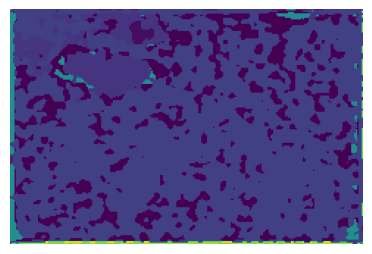

In [9]:
# data = np.load('../unlabeled_masks/2000_mask.npy')
data = torch.load('Paradigm/final_leaderboard_team_18.pt')
print(data.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 2nd subplot
plt.imshow(data[8])
plt.axis('off')

In [114]:
print(device)

mps
